In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import os

In [2]:
import pyroutelib3
from pyroutelib3 import Router
import requests, json
import urllib.parse
import tempfile
import zipfile

In [3]:
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox

# Bases de données de vélos en libre service

In [186]:
temporary_location = tempfile.gettempdir()
def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
  with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

download_unzip('https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12')
communes_borders = gpd.read_file(temporary_location + "/borders/communes-20190101.json")
communes_borders.head()

,insee,nom,wikipedia,surf_ha,geometry
0,97223,Saint-Esprit,fr:Saint-Esprit (Martinique),2318,"POLYGON ((-60.93595 14.58812, -60.93218 14.585..."
1,97233,Le Morne-Vert,fr:Le Morne-Vert,1325,"POLYGON ((-61.12165 14.71928, -61.11852 14.716..."
2,97208,Fonds-Saint-Denis,fr:Fonds-Saint-Denis,2374,"POLYGON ((-61.13355 14.74657, -61.13066 14.748..."
3,97224,Saint-Joseph,fr:Saint-Joseph (Martinique),4324,"POLYGON ((-61.08459 14.72510, -61.08430 14.722..."
4,97212,Gros-Morne,fr:Gros-Morne,4601,"POLYGON ((-61.08459 14.72510, -61.08061 14.725..."


## Velib - disponibilité en temps réel

Données disponibles au lien suivant : 
https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/export/?disjunctive.name&disjunctive.is_installed&disjunctive.is_renting&disjunctive.is_returning&disjunctive.nom_arrondissement_communes

In [187]:
velib = gpd.read_file("https://smartregionidf.opendatasoft.com/explore/dataset/velib-disponibilite-en-temps-reel/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

## Cristolib et Vélo2 en libre-service à Créteil

Données disponibles aux liens suivants : 
- https://smartregionidf.opendatasoft.com/explore/dataset/cristolib_-_velos_en_libre-service_a_creteil/information/
- https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/information/


In [188]:
velos2 = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/download/?format=geojson&timezone=Europe/Berlin&lang=fr')
cristolib = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/cristolib_-_velos_en_libre-service_a_creteil/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

## Veligo

Données disponibles au lien suivant : https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/information/

In [189]:
veligo = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/points-de-contact-veligo-location/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

## VélO2 et Cristolib et Vélo2 en libre-service dans le 95

Données disponibles aux liens suivants : 
- https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/information/
- https://smartregionidf.opendatasoft.com/explore/dataset/velo2_-_cergy-pontoise_et_communes_limitrophes/information/

In [190]:
cristolib_95 = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/jcdecaux-bike-stations-data/download/?format=geojson&timezone=Europe/Berlin&lang=fr')
velos2_95 = gpd.read_file('https://smartregionidf.opendatasoft.com/explore/dataset/velo2_-_cergy-pontoise_et_communes_limitrophes/download/?format=geojson&timezone=Europe/Berlin&lang=fr')

## Fusion des bases de données Vélib, Veligo, Cristolib, Velos2

In [191]:
velib = velib[["name","geometry"]]

veligo = veligo [["nom","geometry"]]
veligo.columns = ['name','geometry']

velos2 = velos2 [["name", "geometry"]]
cristolib = cristolib [["name", "geometry"]]

velos2_95 = velos2 [["name", "geometry"]]
cristolib_95 = cristolib [["name", "geometry"]]

In [192]:
velos = pd.concat([veligo, velib, velos2, cristolib, velos2_95, cristolib_95], ignore_index=True)

In [193]:
velos.shape

(2603, 2)

In [194]:
velos.shape[0] ==  veligo.shape[0] + velib.shape[0] + velos2.shape[0] + cristolib.shape[0] + velos2_95.shape[0] + cristolib_95.shape[0]

True

In [195]:
data_borders = communes_borders.set_index('insee')
data_borders['dep'] = data_borders.index.str[:2]

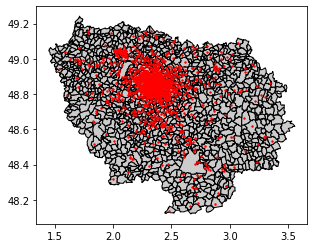

In [196]:
fig, ax = plt.subplots()
data_borders.loc[data_borders['dep'].isin(['75','77', '78', '91','92','93','94', '95'])].plot(ax=ax, color='0.8', edgecolor='black')
velos.plot(ax=ax, color='red', markersize=2)
plt.show()

In [197]:
amenagements = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/33d97256-1829-41d3-b7b5-56e490846b85")
#https://www.data.gouv.fr/fr/datasets/amenagements-velo-en-ile-de-france-2/#_

In [198]:
#pour simplifier on elève les pistes qui ne sont pas à double sens 
am = amenagements.dropna(subset = ['ad','ag']) 
#am.count()
#on perd 1000 observations à peu près 
#am['ad'].unique()

In [199]:
#on simplifie les types de pistes
conditionlist = [
                 (am['ad'].isin(['chemin service site propre uni','chemin dedie uni','autre chemin velo uni'])), 
                 (am['ad'].isin(['cheminement trottoir uni','piste trottoir uni'])),
                 (am['ad'].isin(['piste uni', 'piste bi'])),
                 (am['ad'].isin(['bande uni', 'bande bi', 'DSC bande'])),
                 (am['ad'].isin(['voie verte uni'])),
                 (am['ad'].isin(['voie bus uni']))]
choicelist = ['voie propre', 'trottoir', 'piste', 'bande', 'voie verte', 'voie bus']
am['type'] = np.select(conditionlist, choicelist, default = 'Not Specified')

/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [155]:
conditionlist = [
                 (am['type'].isin(['voie propre'])), 
                 (am['type'].isin(['piste'])),
                 (am['type'].isin(['voie verte'])),
                 (am['type'].isin(['bande'])),
                 (am['type'].isin(['trottoir'])),
                 (am['type'].isin(['voie bus']))]
choicelist = [1, 2, 3, 4, 5, 6]
am['idtype'] = np.select(conditionlist, choicelist, default = 'Not Specified')

In [156]:
am['idtype'] = am['idtype'].str.replace(',','.').astype(float)
#am.dtypes
am = am.to_json()

In [208]:
centre = [48.8534 , 2.3488] #le centre de paris 
idf = folium.Map(location = centre, zoom_start = 11) #zoom = 11 permet de voir toute l'idf, à modifier en fct de l'utilisation de l'appli 
#idf.add_child(folium.GeoJson(am))
idf

# Choix du point de départ et du point d'arrivée

In [159]:
application_window = tk.Tk()
adresse_depart = simpledialog.askstring("Adresse départ", "D'où partez-vous ? (numéro, rue, code postal ville)",
                                parent=application_window)
adresse_arrivee = simpledialog.askstring("Adresse arrivée", "Où voulez-vous aller ? (numéro, rue, code postal ville)",
                                parent=application_window)

In [160]:
#est-ce qu'on ne pourrait pas plutôt calculer les deux trajets automatiquement et proposer les deux à la fin ? 
a = messagebox.askquestion("Type de trajet", "Préférez-vous un trajet rapide plutôt qu'un trajet agréable?")
if a == 'yes':
  #on recherche le trajet le plus rapide
else : 
  #on recherche le trajet le plus agréable

IndentationError: expected an indented block (<ipython-input-160-004f02cf5672>, line 5)

In [161]:
#adresse_depart = "57, avenue du Plessis, 92350 Le Plessis Robinson"
#adresse_arrivee = "3, avenue de Verdun, 92120 Montrouge"dep_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_depart) + "&format=json").json()
arr_json = requests.get("https://api-adresse.data.gouv.fr/search/?q=" + urllib.parse.quote(adresse_arrivee) + "&format=json").json()
coord_dep = list(dep_json['features'][0].get('geometry').get('coordinates'))
coord_arr = list(arr_json['features'][0].get('geometry').get('coordinates'))
coord_dep
coord_arr

[2.316016, 48.812058]

## Lorsque l'utilisateur n'a pas son propre vélo

In [200]:
# Calcul de la distance en km entre le point de départ et toutes les stations

distances = []
for i in range(len(velib.geometry)):
  a = (max(velib.geometry[i].x, coord_dep[0]) - min(velib.geometry[i].x, coord_dep[0]))**2 + (max(velib.geometry[i].y, coord_dep[1]) - min(velib.geometry[i].y, coord_dep[1]))**2
  a = a**(1/2)*100
  distances.append(a)

In [201]:
#Station la plus proche du point de départ 

i = distances.index(min(distances))

station_dep = [velib["geometry"][i].y, velib["geometry"][i].x]

print( 'Station la plus proche : \n', velib["name"][i] )
print( '\n \nDistance point d arrivee -> station:\n', min(distances), "km")

Station la plus proche : 
 Gare de Robinson

 
Distance point d arrivee -> station:
 0.42876317497965233 km


In [202]:
# Calcul de la distance en km entre le point d'arrivée et toutes les stations

distances = []
for i in range(len(velib.geometry)):
  a = (max(velib.geometry[i].x, coord_arr[0]) - min(velib.geometry[i].x, coord_arr[0]))**2 + (max(velib.geometry[i].y, coord_arr[1]) - min(velib.geometry[i].y, coord_arr[1]))**2
  a = a**(1/2)*100
  distances.append(a)

In [203]:
#Station la plus proche du point d'arrivée

j = distances.index(min(distances))

station_arr = [velib["geometry"][j].y, velib["geometry"][j].x] 

print( 'Station la plus proche du point d arrivée: \n', velib["name"][j] )
print( '\n \nDistance station -> point d arrivee :\n', min(distances), "km")

Station la plus proche du point d arrivée: 
 Molière - République

 
Distance station -> point d arrivee :
 0.17226361742954557 km


# Trajet à pied : point de départ -> station départ

In [211]:
coor_depart = [coord_dep[1], coord_dep[0]] 
coor_arrivee = [coord_arr[1], coord_arr[0]] 

folium.Marker(coor_depart,popup="Départ").add_to(idf)
folium.Marker(coor_arrivee,popup="Arrivée").add_to(idf)

In [209]:
router = pyroutelib3.Router("foot")

depart = router.findNode(coor_depart[0], coor_depart[1])
arrivee = router.findNode(station_dep[0], station_dep[1])

routeLatLons=[coor_depart,station_dep]
status, route = router.doRoute(depart, arrivee)
if status == 'success':
  print("votre trajet existe")
  routeLatLons = list(map(router.nodeLatLon, route))
else:
  print("votre trajet n'existe pas")

#print(routeLatLons)
for coord in routeLatLons:
  coord=list(coord)
  folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)

votre trajet existe


In [212]:
idf

# Trajet en vélo : station départ -> station arrivée

In [213]:
router = pyroutelib3.Router("cycle")
depart = router.findNode(station_dep[0], station_dep[1])
print(depart)
arrivee = router.findNode(station_arr[0], station_arr[1])
print(arrivee)

routeLatLons=[station_dep,station_arr]
status, route = router.doRoute(depart, arrivee)
if status == 'success':
  print("votre trajet existe")
  routeLatLons = list(map(router.nodeLatLon, route))
else:
  print("votre trajet n'existe pas")

#print(routeLatLons)
for coord in routeLatLons:
  coord=list(coord)
  folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

folium.PolyLine(routeLatLons, color="red", weight=2.5, opacity=1).add_to(idf)

2385606921
4565621055
votre trajet existe


In [214]:
idf

# Trajet à pied : station arrivée -> point d'arrivée

In [215]:
router = pyroutelib3.Router("foot")
depart = router.findNode(station_arr[0], station_arr[1])
arrivee = router.findNode(coor_arrivee[0], coor_arrivee[1])

routeLatLons=[station_arr, coor_arrivee]
status, route = router.doRoute(depart, arrivee)
if status == 'success':
  print("votre trajet existe")
  routeLatLons = list(map(router.nodeLatLon, route))
else:
  print("votre trajet n'existe pas")

#print(routeLatLons)
for coord in routeLatLons:
  coord=list(coord)
  folium.CircleMarker(coord,radius = 3,fill=True, color='green').add_to(idf)

folium.PolyLine(routeLatLons, color="black", weight=2.5, opacity=1).add_to(idf)

votre trajet existe


In [216]:
idf